## Imports

In [1]:
import os
import sys
import glob
import logging
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from monai.networks.layers import Reshape

from monai.transforms import (
    LoadImage,
    EnsureChannelFirst,
    Compose,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    EnsureType,
    Transform,
    Resize,
    CenterSpatialCrop,
    AdjustContrast
)

from monai.data import CacheDataset, DataLoader
from monai.visualize import matshow3d, img2tensorboard
from monai.utils import first, set_determinism
from monai.apps import get_logger

## Define run name and paths

In [2]:
RESUME_TRAINING = False # if set to TRUE provide run_name to continue
run_name = ''

In [3]:
save_path = '/data2/etude/micorl/WGAN'

if not RESUME_TRAINING:
    run_name = datetime.now().strftime("%d-%m-%Y_%H:%M")

logs_path = os.path.join(save_path, 'logs/', run_name)

checkpoint_name = f'checkpoint_{run_name}.pt'
checkpoint_path = os.path.join(save_path, 'models/', checkpoint_name)

## Determinism, device and logger

In [4]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
2
0
NVIDIA TITAN RTX


In [5]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
get_logger('train_log')
set_determinism(0)
device = torch.device('cuda:0')

In [6]:
torch.cuda.empty_cache()
torch.cuda.memory_stats()
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

## Load and prepare dataset

In [7]:
image_size = 256
num_slices = 128
contrast_gamma = 1.5
every_n_slice = 8
batch_size = 1

learning_rate = 1e-4
channels = 1
num_epochs = 200
latent_size = 100
critic_features = 16
generator_features = 16
critic_iterations = 3
lambda_gp = 10 # controls how much of gradient penalty will be added to critic loss

In [8]:
data_dir = '/data1/dose-3d-generative/data_med/PREPARED/FOR_AUG'
directory = os.path.join(data_dir, 'ct_images')
images_pattern = os.path.join(directory, '*.nii.gz')
images = sorted(glob.glob(images_pattern))[:20]

train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        CenterSpatialCrop((400, 400, 0)),
        Resize((image_size, image_size, num_slices)),
        ScaleIntensity(),
        AdjustContrast(contrast_gamma),
        RandRotate(range_x=np.pi/12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureType()
    ]
)

dataset = CacheDataset(images, train_transforms)
loader = torch.utils.data.DataLoader(dataset, num_workers=10, shuffle=True, pin_memory=torch.cuda.is_available())

Loading dataset: 100%|██████████| 2/2 [00:04<00:00,  2.27s/it]


(1, 1, 256, 256, 128)


(<Figure size 1000x1000 with 1 Axes>,
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        ...,
        [nan,  0.,  0., ...,  0.,  0., nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32))

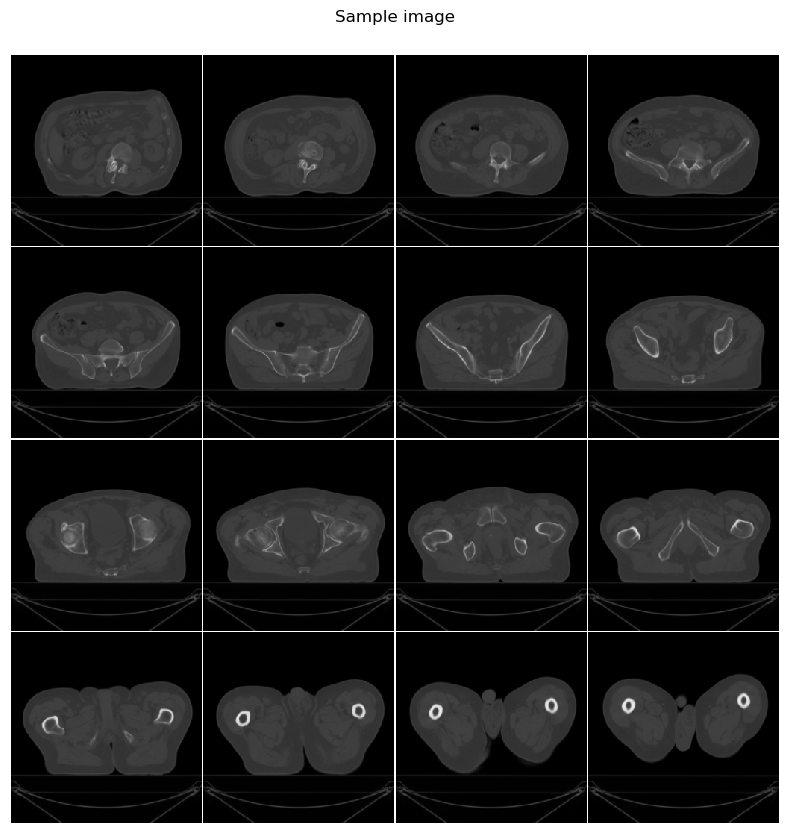

In [9]:
image_sample = first(loader)
print(image_sample.shape)

fig = plt.figure(figsize=(15,15))
matshow3d(volume=image_sample,
          fig=fig,
          title="Sample image",
          every_n=every_n_slice,
          frame_dim=-1,
          cmap="gray")

## Define model architecture

In [10]:
class Critic(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Critic, self).__init__()
        
        self.net = nn.Sequential(
            self._block(1, 8, 4, 2, 1),
            self._block(8, 16, 4, 2, 1),
            self._block(16, 32, 4, 2, 1),
            self._block(32, 64, 4, 2, 1),
            self._block(64, 128, 4, 2, 1),
            self._block(128, 128, 3, (2,2,1), 1),
            nn.Conv3d(128, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv3d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        x = self.net(x)
        return x


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()

        self.linear = nn.Linear(100, 256*8*8*4)
        self.reshape = Reshape(256, 8, 8, 4)

        self.net = nn.Sequential(
            self._block(256, 128, 4, 2, 1),
            self._block(128, 64, 4, 2, 1),
            self._block(64, 32, 4, 2, 1),
            self._block(32, 8, 4, 2, 1),
            self._block(16, 8, 4, 2, 1),
            self._block(8, 1, 3, 1, 1),
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose3d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.linear(x)
        x = self.reshape(x)
        x = self.net(x)
        return x

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv3d, nn.ConvTranspose3d, nn.BatchNorm3d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

def gradient_penalty(critic, real, fake, device='cpu'):
    batch_size, c, h, w, d = real.shape
    alpha = torch.rand((batch_size, 1, 1, 1, 1)).repeat(1, c, h, w, d).to(device)

    # calculate interpolated/mean images using random vector alpha and 1-alpha
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)
    #print('1 ', mixed_scores.shape)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    
    # reshape gradient to vector, calculate norm
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    
    # calculate gradient penalty
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)

    return gradient_penalty

def test():
    N, in_channels, H, W, D = 1, 1, 256, 256, 128
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W, D))
    disc = Critic(in_channels, 8)
    out_d = disc(x)
    print(out_d.shape)
    assert disc(x).shape == (N, 1, 4, 4, 4), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn(1, noise_dim)
    out_g = gen(z)
    print(out_g.shape)
    assert out_g.shape == (N, in_channels, H, W, D), "Generator test failed"
    print("Success, tests passed!")

test()

torch.Size([1, 1, 4, 4, 4])
torch.Size([1, 1, 256, 256, 128])
Success, tests passed!


## Initialize and train model

In [11]:
# create and initialize networks

critic = Critic(channels, critic_features).to(device)
initialize_weights(critic)

generator = Generator(latent_size, channels, generator_features).to(device)
initialize_weights(generator)

In [12]:
# initialize optimizers

opt_critic = optim.Adam(critic.parameters(), lr=learning_rate, betas=(0.0, 0.9))
opt_generator = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.0, 0.9))

In [13]:
writer_real = SummaryWriter(logs_path + '/real')
writer_fake = SummaryWriter(logs_path + '/fake')
writer_real_gif = SummaryWriter(logs_path + '/real_gif')
writer_fake_gif = SummaryWriter(logs_path + '/fake_gif')
writer_loss_step = SummaryWriter(logs_path + '/loss_step')
writer_loss_epoch = SummaryWriter(logs_path + '/loss_epoch')

In [14]:
def save_model(epoch, step):
    state = {
        'epoch': epoch + 1,
        'step': step,
        'generator': generator.state_dict(),
        'critic': critic.state_dict(),
        'opt_generator': opt_generator.state_dict(),
        'opt_critic': opt_critic.state_dict(),
    }

    torch.save(state, checkpoint_path)

In [15]:
# load state if resuming training
if RESUME_TRAINING:
    state = torch.load(checkpoint_path)
    critic.load_state_dict(state['critic'])
    generator.load_state_dict(state['generator'])
    opt_critic.load_state_dict(state['opt_critic'])
    opt_generator.load_state_dict(state['opt_generator'])
    step = state['step']
    start_epoch = state['epoch']
    num_epochs = start_epoch + num_epochs
else:
    step = 0
    start_epoch = 0

In [16]:
critic.train()
generator.train()

for epoch in range(start_epoch, num_epochs):
    curr_epoch_loss_gen_sum = 0
    curr_epoch_loss_crit_sum = 0
    for batch_idx, real in enumerate(loader):
        real = real.to(device)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # equivalent to minimizing the negative of that
        for _ in range(critic_iterations):
            noise = torch.randn(cur_batch_size, latent_size).to(device)
            fake = generator(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + lambda_gp * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        generator_fake = critic(fake).reshape(-1)
        loss_generator = -torch.mean(generator_fake)
        generator.zero_grad()
        loss_generator.backward()
        opt_generator.step()
        writer_loss_step.add_scalar("Step loss Generator", loss_generator, global_step=step)
        writer_loss_step.add_scalar("Step loss Crit", loss_critic, global_step=step)
        curr_epoch_loss_gen_sum += loss_generator.item()
        curr_epoch_loss_crit_sum += loss_critic.item()
        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_generator:.4f}"
            )

            with torch.no_grad():
                fake = generator(noise)
                fig_real = plt.figure(figsize=(15,15))
                matshow3d(volume=real, fig=fig_real, title="real", every_n=2, frame_dim=-1, cmap="gray")
                fig_fake = plt.figure(figsize=(15,15))
                matshow3d(volume=fake, fig=fig_fake, title="fake", every_n=2, frame_dim=-1, cmap="gray")
                img2tensorboard.plot_2d_or_3d_image(data=real, step=step, writer=writer_real_gif, frame_dim=-1)
                img2tensorboard.plot_2d_or_3d_image(data=fake, step=step, writer=writer_fake_gif, frame_dim=-1)
                
                writer_real.add_figure("Real", fig_real, global_step=step)
                writer_fake.add_figure("Fake", fig_fake, global_step=step)

        step += 1

    if epoch % 10 == 0:
        save_model(epoch, step)

    loss_gen_epoch = curr_epoch_loss_gen_sum / len(loader)
    loss_crit_epoch = curr_epoch_loss_crit_sum / len(loader)
    print(f"Generator mean loss in epoch:{loss_gen_epoch}")
    writer_loss_epoch.add_scalar("Epoch loss Generator", loss_gen_epoch, global_step=epoch)
    writer_loss_epoch.add_scalar("Epoch loss Crit", loss_crit_epoch, global_step=epoch)

RuntimeError: cuDNN error: CUDNN_STATUS_INTERNAL_ERROR

In [ ]:
noise = torch.randn(1, latent_size).to(device)
with torch.no_grad():
    fake = generator(noise)
    fig = plt.figure(figsize=(15,15))
    matshow3d(volume=fake,
            fig=fig,
            title="Generated image",
            every_n=every_n_slice,
            frame_dim=-1,
            cmap="gray")

In [ ]:
save_model(epoch, step)